In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Creating the 1000-state random walk Env.

In [2]:
# number of states except for terminal states
N_STATES = 1000
N_GROUPS = 10
GROUP_SIZE = N_STATES // N_GROUPS
# true state values, just a promising guess
trueStateValues = np.arange(-1001, 1003, 2) / 1001.0
# all states
states = np.arange(1, N_STATES + 1)
# start from a central state
START_STATE = 500
# terminal states
END_STATES = [0, N_STATES + 1]
# possible actions
ACTION_LEFT = -1
ACTION_RIGHT = 1
ACTIONS = [ACTION_LEFT, ACTION_RIGHT]
# maximum stride for an action
STEP_RANGE = 100

## Finding the True value of each state

In [3]:
# Dynamic programming to find the true state values, based on the promising guess above
# Assume all rewards are 0, given that we have already given value -1 and 1 to terminal states
while True:
    oldTrueStateValues = np.copy(trueStateValues)
    for state in states:
        trueStateValues[state] = 0
        for action in ACTIONS:
            for step in range(1, STEP_RANGE + 1):
                step *= action
                newState = state + step
                newState = max(min(newState, N_STATES + 1), 0)
                # asynchronous update for faster convergence
                trueStateValues[state] += 1.0 / (2 * STEP_RANGE) * trueStateValues[newState]
    error = np.sum(np.abs(oldTrueStateValues - trueStateValues))
    print(error)
    if error < 1e-2:
        break
# correct the state value for terminal states to 0
trueStateValues[0] = trueStateValues[-1] = 0

5.219856250608928
3.147504764133215
2.4200165327442447
2.030964368597748
1.765774604834791
1.559756160711911
1.3875884847630768
1.2382446653845665
1.1064473413428413
0.9892874551215542
0.8848433975962106
0.7916155616180749
0.7083377975538772
0.6338945041405755
0.5672963336491752
0.5076722536530798
0.45426128102798813
0.40640673995613064
0.3635334477225872
0.3251406600343595
0.29078547835741864
0.260072448727817
0.23264633333457801
0.2081849989696269
0.1863964885141361
0.16701502587432657
0.14980032427970585
0.13453281651165322
0.12101479793777228
0.10906668626498445
0.0985270181556287
0.08925010666481309
0.08110473842855008
0.07397312225969863
0.06774966858962844
0.06233968094702404
0.05765814517708229
0.05362893012631888
0.050183422469906966
0.047259943409262505
0.04480246726853935
0.04275906137304951
0.04108202401984219
0.039724016015922965
0.03863474194706377
0.03774650233089469
0.03693004490122122
0.03610614770720546
0.03527755633058373
0.03444759318230696
0.033619139204445946
0.03

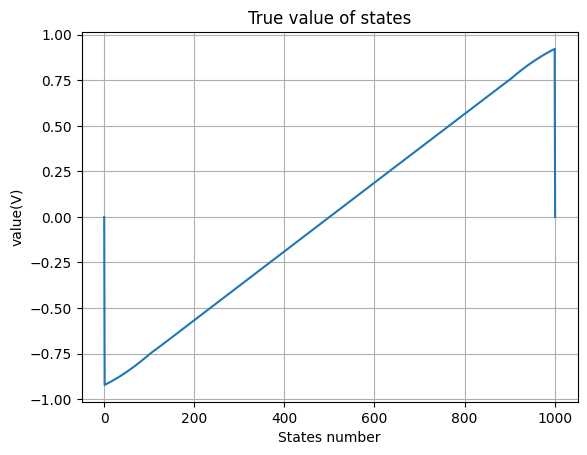

In [4]:
plt.plot(trueStateValues)
plt.xlabel('States number')
plt.ylabel('value(V)')
plt.title('True value of states')
plt.grid(True)

## Define some function for the Env

In [5]:
# take an @action at @state, return new state and reward for this transition
def takeAction(state, action):
    step = np.random.randint(1, STEP_RANGE + 1)
    step *= action
    state += step
    state = max(min(state, N_STATES + 1), 0)
    if state == 0:
        reward = -1
    elif state == N_STATES + 1:
        reward = 1
    else:
        reward = 0
    return state, reward

In [6]:
def getAction():
    if np.random.random() <= 0.5:
        return -1
    return 1

In [86]:
def feature_vector(state, n_groups):
    x = np.zeros(N_STATES)
    group_size = N_STATES // n_groups
    group_index = (state - 1) // group_size
    mask = np.arange(group_index * group_size, (group_index + 1) * group_size)
    x[mask] = 1
    return x

In [8]:
W_HISTORY = [[0] for _ in range(N_GROUPS)]

### Gradient Monte Carlo method with state agrregation

In [69]:
def gradient_monte_carlo(alpha, distribution):
    global W, W_HISTORY, RMS_ERROR
    currentState = START_STATE
    trajectory = [currentState]
    # We assume gamma = 1, so return is just the same as the latest reward
    reward = 0.0

    while currentState not in END_STATES:
        action = getAction()
        newState, reward = takeAction(currentState, action)
        trajectory.append(newState)
        currentState = newState
    # Gradient update for each state in this trajectory
    for state in trajectory[:-1]:
        x = feature_vector(state, n_groups=N_GROUPS)
        v_hat = np.inner(W, x)
        delta = alpha * (reward - v_hat) * x
        W += delta
        group_index = (state - 1) // GROUP_SIZE
        W_HISTORY[group_index].append(W[group_index * GROUP_SIZE + 2])

        if distribution is not None:
            distribution[state] += 1


Streaming output truncated to the last 5000 lines.
episode: 95000
episode: 95001
episode: 95002
episode: 95003
episode: 95004
episode: 95005
episode: 95006
episode: 95007
episode: 95008
episode: 95009
episode: 95010
episode: 95011
episode: 95012
episode: 95013
episode: 95014
episode: 95015
episode: 95016
episode: 95017
episode: 95018
episode: 95019
episode: 95020
episode: 95021
episode: 95022
episode: 95023
episode: 95024
episode: 95025
episode: 95026
episode: 95027
episode: 95028
episode: 95029
episode: 95030
episode: 95031
episode: 95032
episode: 95033
episode: 95034
episode: 95035
episode: 95036
episode: 95037
episode: 95038
episode: 95039
episode: 95040
episode: 95041
episode: 95042
episode: 95043
episode: 95044
episode: 95045
episode: 95046
episode: 95047
episode: 95048
episode: 95049
episode: 95050
episode: 95051
episode: 95052
episode: 95053
episode: 95054
episode: 95055
episode: 95056
episode: 95057
episode: 95058
episode: 95059
episode: 95060
episode: 95061
episode: 95062
epis

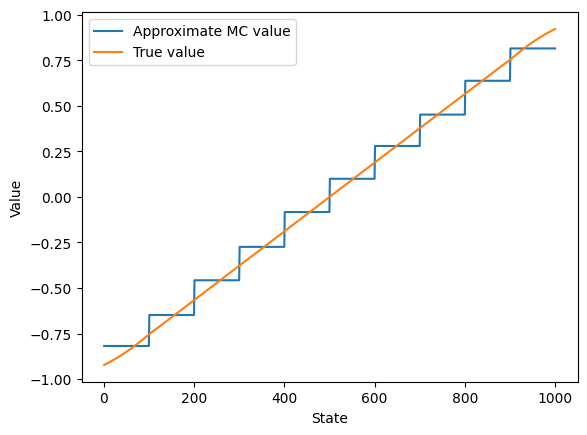

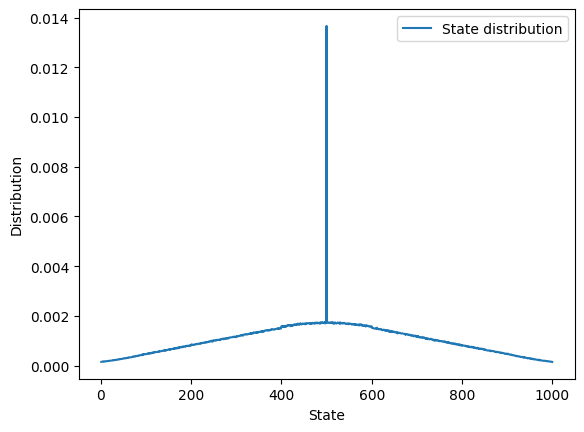

In [73]:
W = np.zeros(N_STATES)
RMS_ERROR = [[0] for _ in range(N_GROUPS)]
nEpisodes = int(1e5)
w_list = []
alpha = 2e-7
distribution = np.zeros(N_STATES + 2)
for episode in range(0, nEpisodes):
    print('episode:', episode)
    gradient_monte_carlo(alpha, distribution)
    for i in range(N_GROUPS):
        x = feature_vector(i*GROUP_SIZE + GROUP_SIZE // 2, N_GROUPS)
        v_hat = np.inner(W, x)
        RMS_ERROR[i].append((v_hat - trueStateValues[i*GROUP_SIZE + GROUP_SIZE // 2])**2)


distribution /= np.sum(distribution)
state_values = [np.inner(W, feature_vector(state, 10)) for state in states]
plt.figure(0)
plt.plot(states, state_values, label='Approximate MC value')
plt.plot(states, trueStateValues[1: -1], label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()
plt.figure(1)
plt.plot(states, distribution[1: -1], label='State distribution')
plt.xlabel('State')
plt.ylabel('Distribution')
plt.legend()

### Plot function

In [74]:
def plot_result(w, title="", ylabel=""):
    i = 0
    j = 0
    fig, ax = plt.subplots(4, 3, figsize=(23, 20))
    for k in range(N_GROUPS):

        ax[i, j].plot(w[k], label=f"Groups: {k}")
        ax[i, j].set_title(title)
        ax[i, j].set_xlabel("Episodes")
        ax[i, j].set_ylabel(ylabel)
        ax[i, j].legend()
        ax[i, j].grid(True)
        j += 1
        if j == 3:
            i += 1
            j = 0

### Plotting the estimated value function

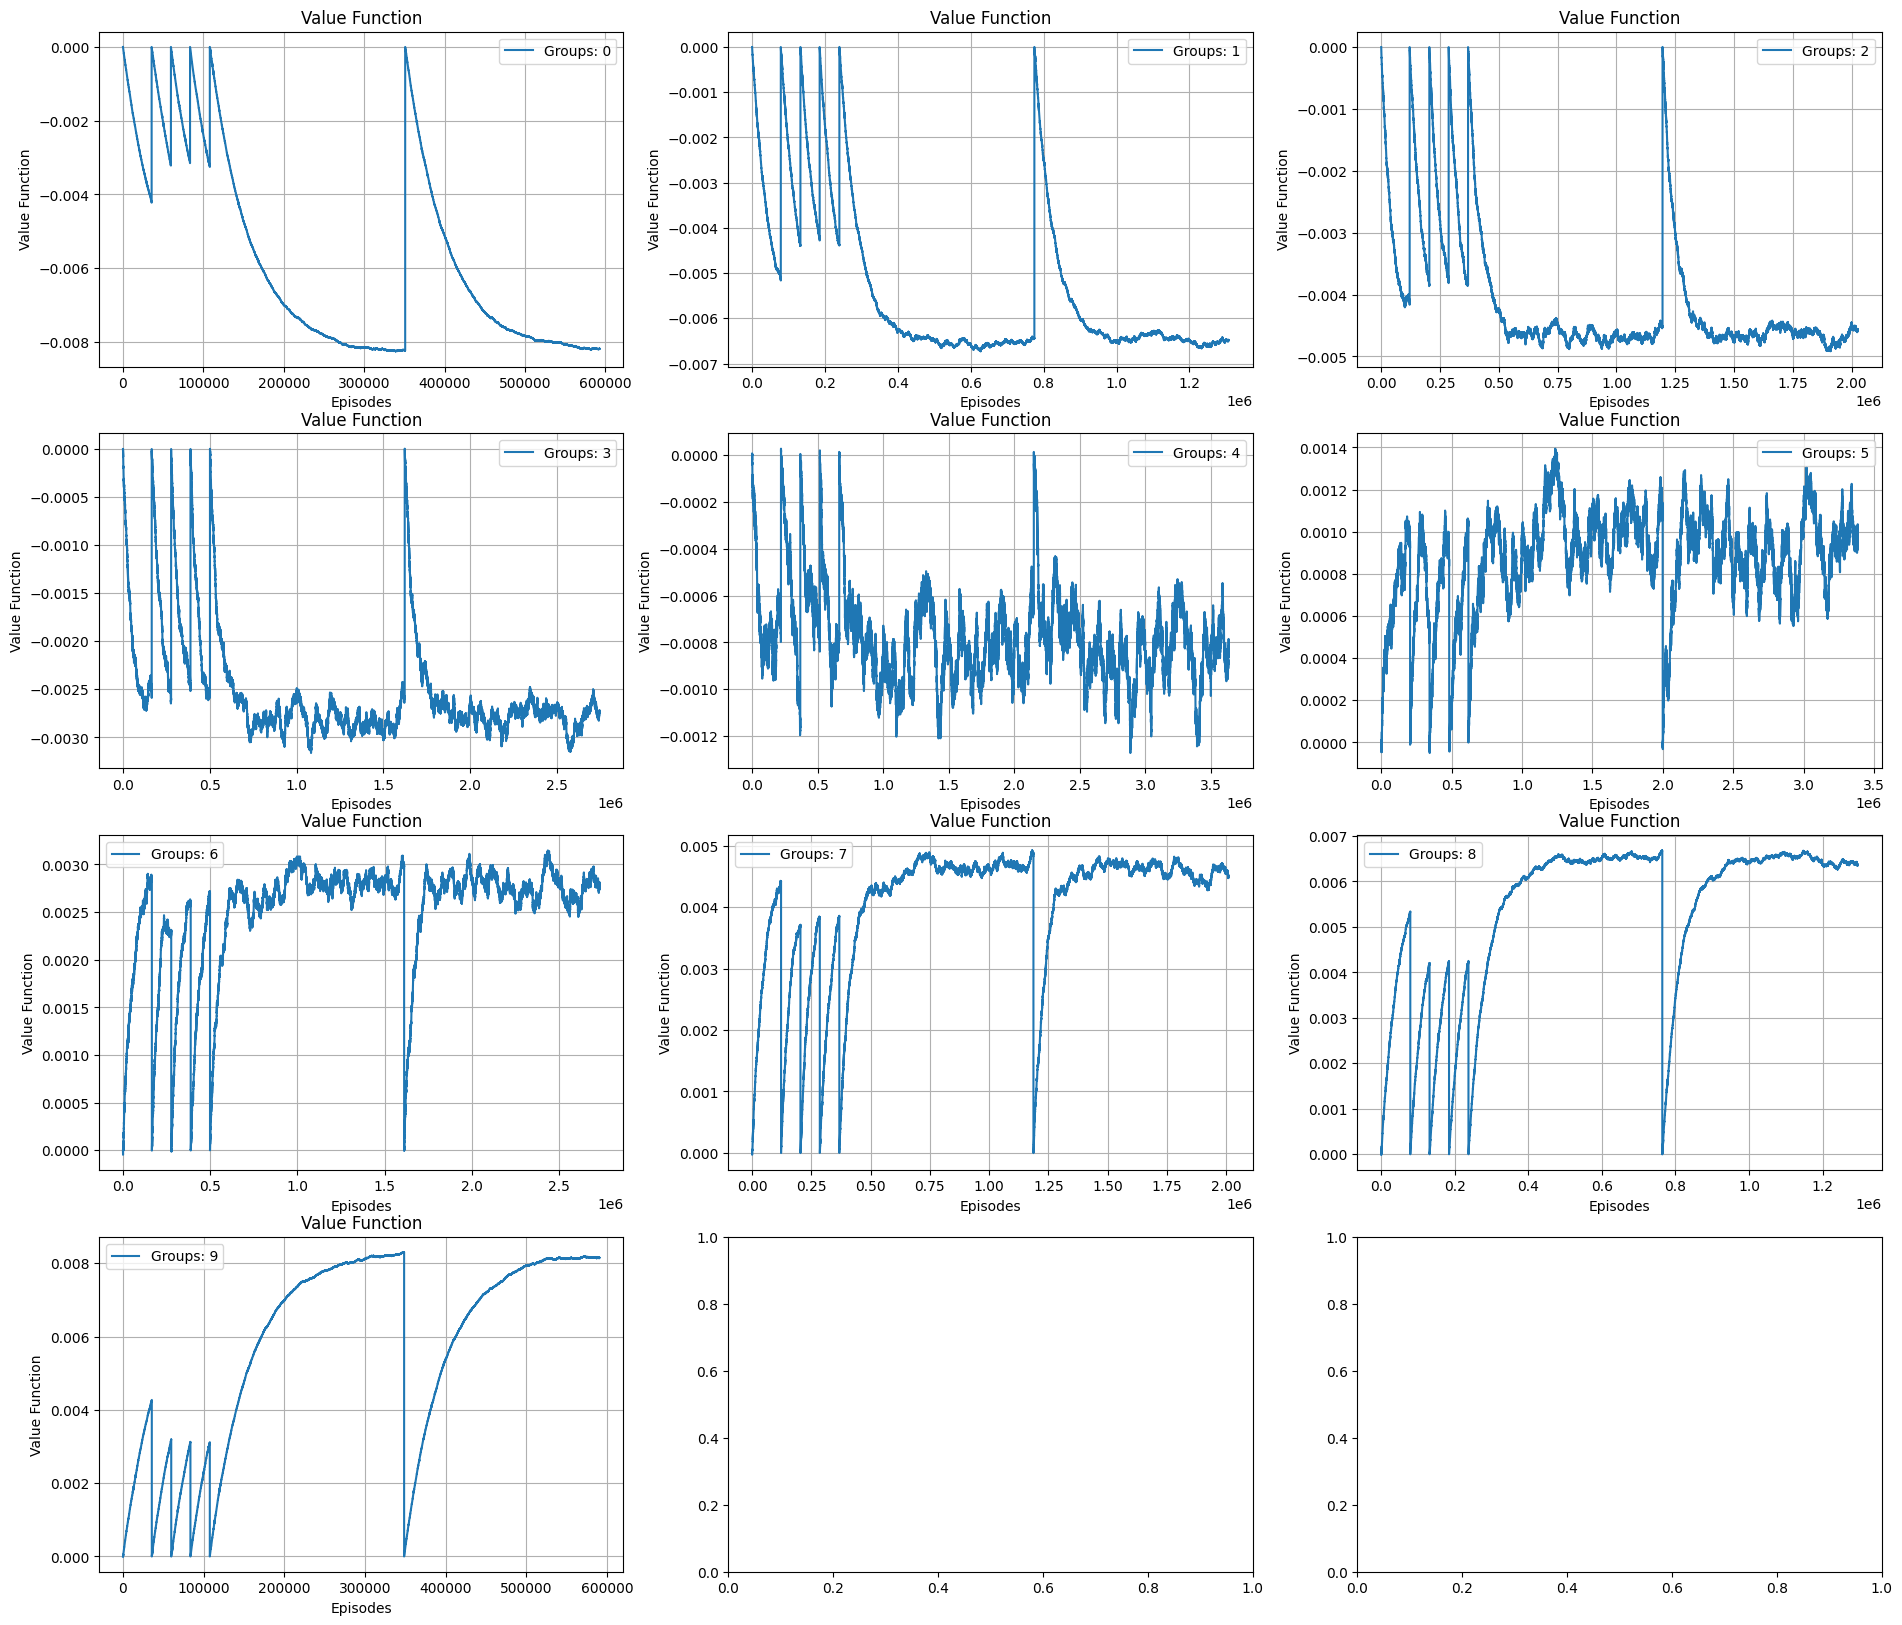

In [75]:
plot_result(W_HISTORY, title="Value Function", ylabel="Value Function")

### Plotting the average RMS error of the result

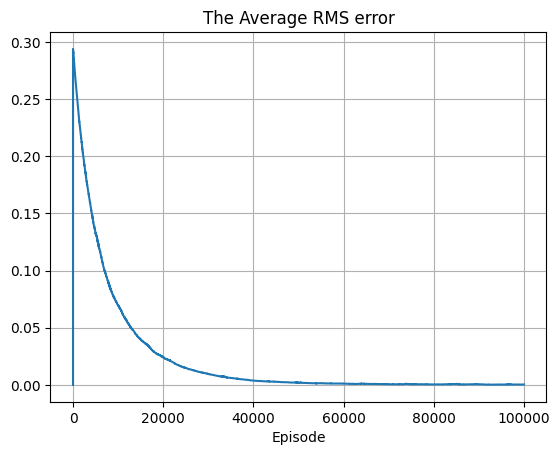

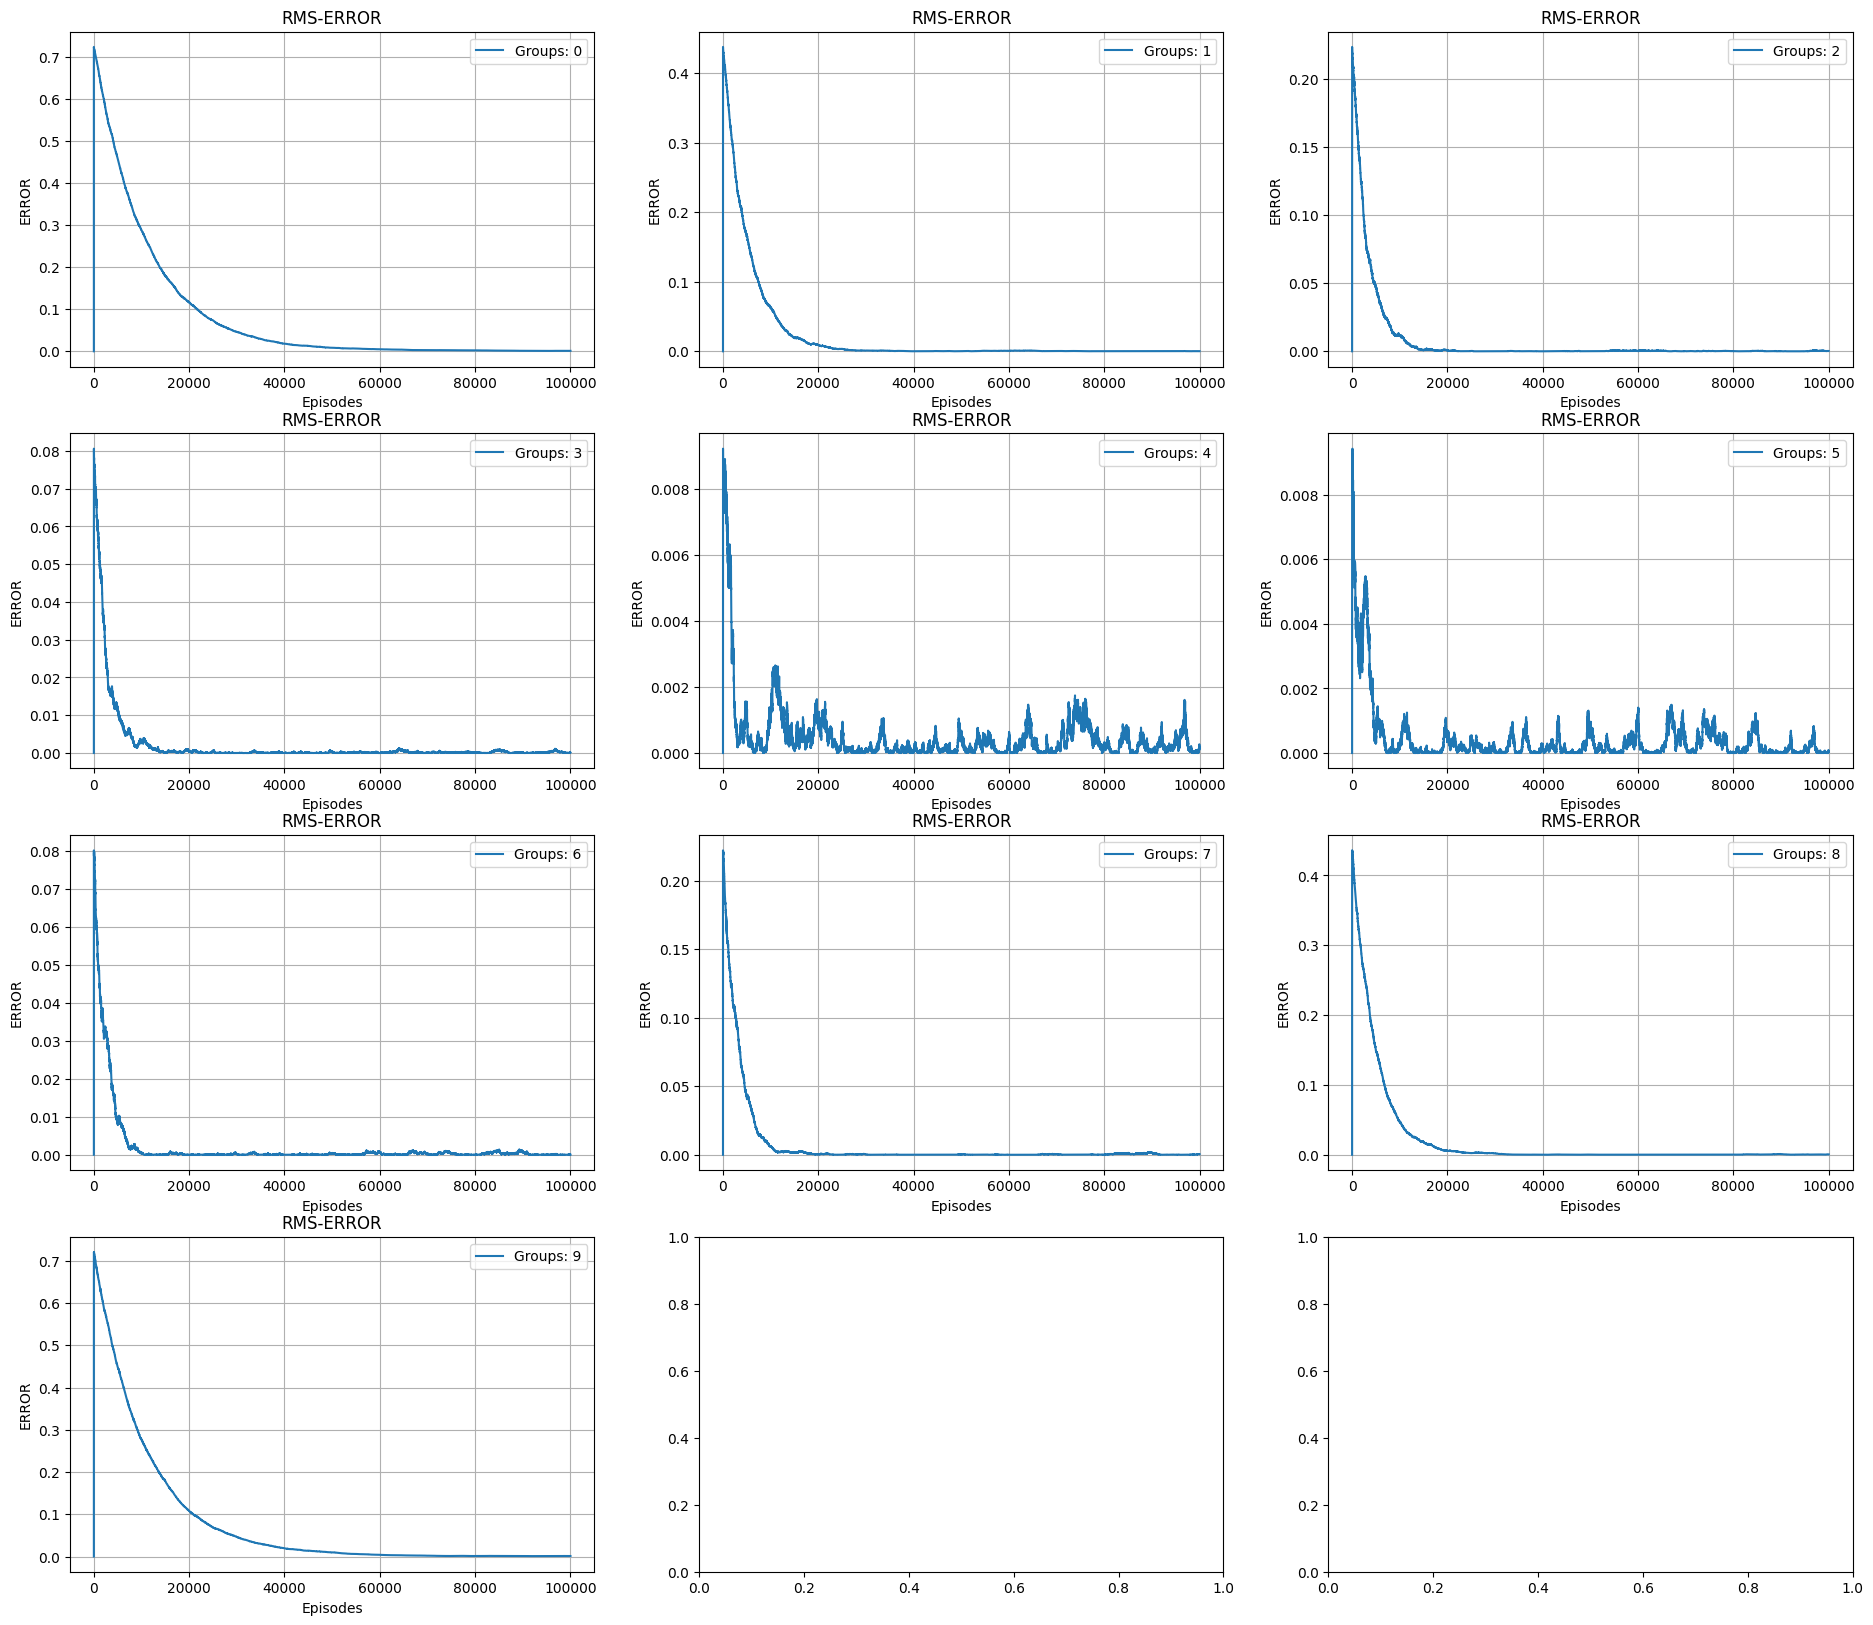

In [76]:
rms_error = np.array(RMS_ERROR)
avg_rms_error = np.mean(rms_error, axis=0)
plt.plot(avg_rms_error)
plt.title("The Average RMS error")
plt.xlabel("Episode")

plt.grid(True)

plot_result(RMS_ERROR, title="RMS-ERROR", ylabel="ERROR")

### Semi-gradient Tempral Difference

In [92]:
def gradient_TD(alpha, distribution):
    global W, W_HISTORY
    currentState = START_STATE
    while currentState not in END_STATES:
        action = getAction()
        newState, reward = takeAction(currentState, action)
        if newState not in END_STATES:
            x_newState = feature_vector(newState, N_GROUPS)
            v_hat_prime = np.inner(W, x_newState)
        else:
            v_hat_prime = 0
        x_currentState = feature_vector(currentState, N_GROUPS)
        v_hat = np.inner(W, x_currentState)

        delta = alpha * (reward + v_hat_prime - v_hat) * x_currentState
        W += delta
        group_index = (currentState - 1) // GROUP_SIZE
        W_HISTORY[group_index].append(W[group_index * GROUP_SIZE + 2])
        currentState = newState


Streaming output truncated to the last 5000 lines.
episode: 45000
episode: 45001
episode: 45002
episode: 45003
episode: 45004
episode: 45005
episode: 45006
episode: 45007
episode: 45008
episode: 45009
episode: 45010
episode: 45011
episode: 45012
episode: 45013
episode: 45014
episode: 45015
episode: 45016
episode: 45017
episode: 45018
episode: 45019
episode: 45020
episode: 45021
episode: 45022
episode: 45023
episode: 45024
episode: 45025
episode: 45026
episode: 45027
episode: 45028
episode: 45029
episode: 45030
episode: 45031
episode: 45032
episode: 45033
episode: 45034
episode: 45035
episode: 45036
episode: 45037
episode: 45038
episode: 45039
episode: 45040
episode: 45041
episode: 45042
episode: 45043
episode: 45044
episode: 45045
episode: 45046
episode: 45047
episode: 45048
episode: 45049
episode: 45050
episode: 45051
episode: 45052
episode: 45053
episode: 45054
episode: 45055
episode: 45056
episode: 45057
episode: 45058
episode: 45059
episode: 45060
episode: 45061
episode: 45062
epis

<ipython-input-96-e91e1cb534c4>:17: RuntimeWarning: invalid value encountered in divide
  distribution /= np.sum(distribution)


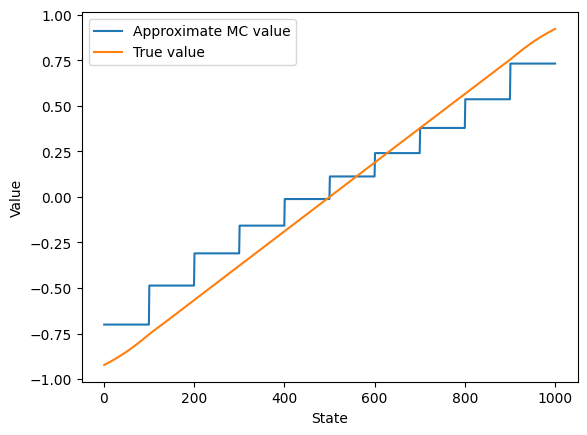

In [96]:
W = np.zeros(N_STATES)
W_HISTORY = [[0] for _ in range(N_GROUPS)]
RMS_ERROR = [[0] for _ in range(N_GROUPS)]
nEpisodes = int(5e4)
w_list = []
alpha = 2e-5
distribution = np.zeros(N_STATES + 2)
for episode in range(0, nEpisodes):
    print('episode:', episode)
    gradient_TD(alpha, distribution)
    for i in range(N_GROUPS):
        x = feature_vector(i*GROUP_SIZE + GROUP_SIZE // 2, N_GROUPS)
        v_hat = np.inner(W, x)
        RMS_ERROR[i].append((v_hat - trueStateValues[i*GROUP_SIZE + GROUP_SIZE // 2])**2)


distribution /= np.sum(distribution)
state_values = [np.inner(W, feature_vector(state, 10)) for state in states]
plt.figure(0)
plt.plot(states, state_values, label='Approximate MC value')
plt.plot(states, trueStateValues[1: -1], label='True value')
plt.xlabel('State')
plt.ylabel('Value')
plt.legend()

### Plotting the estimated value function

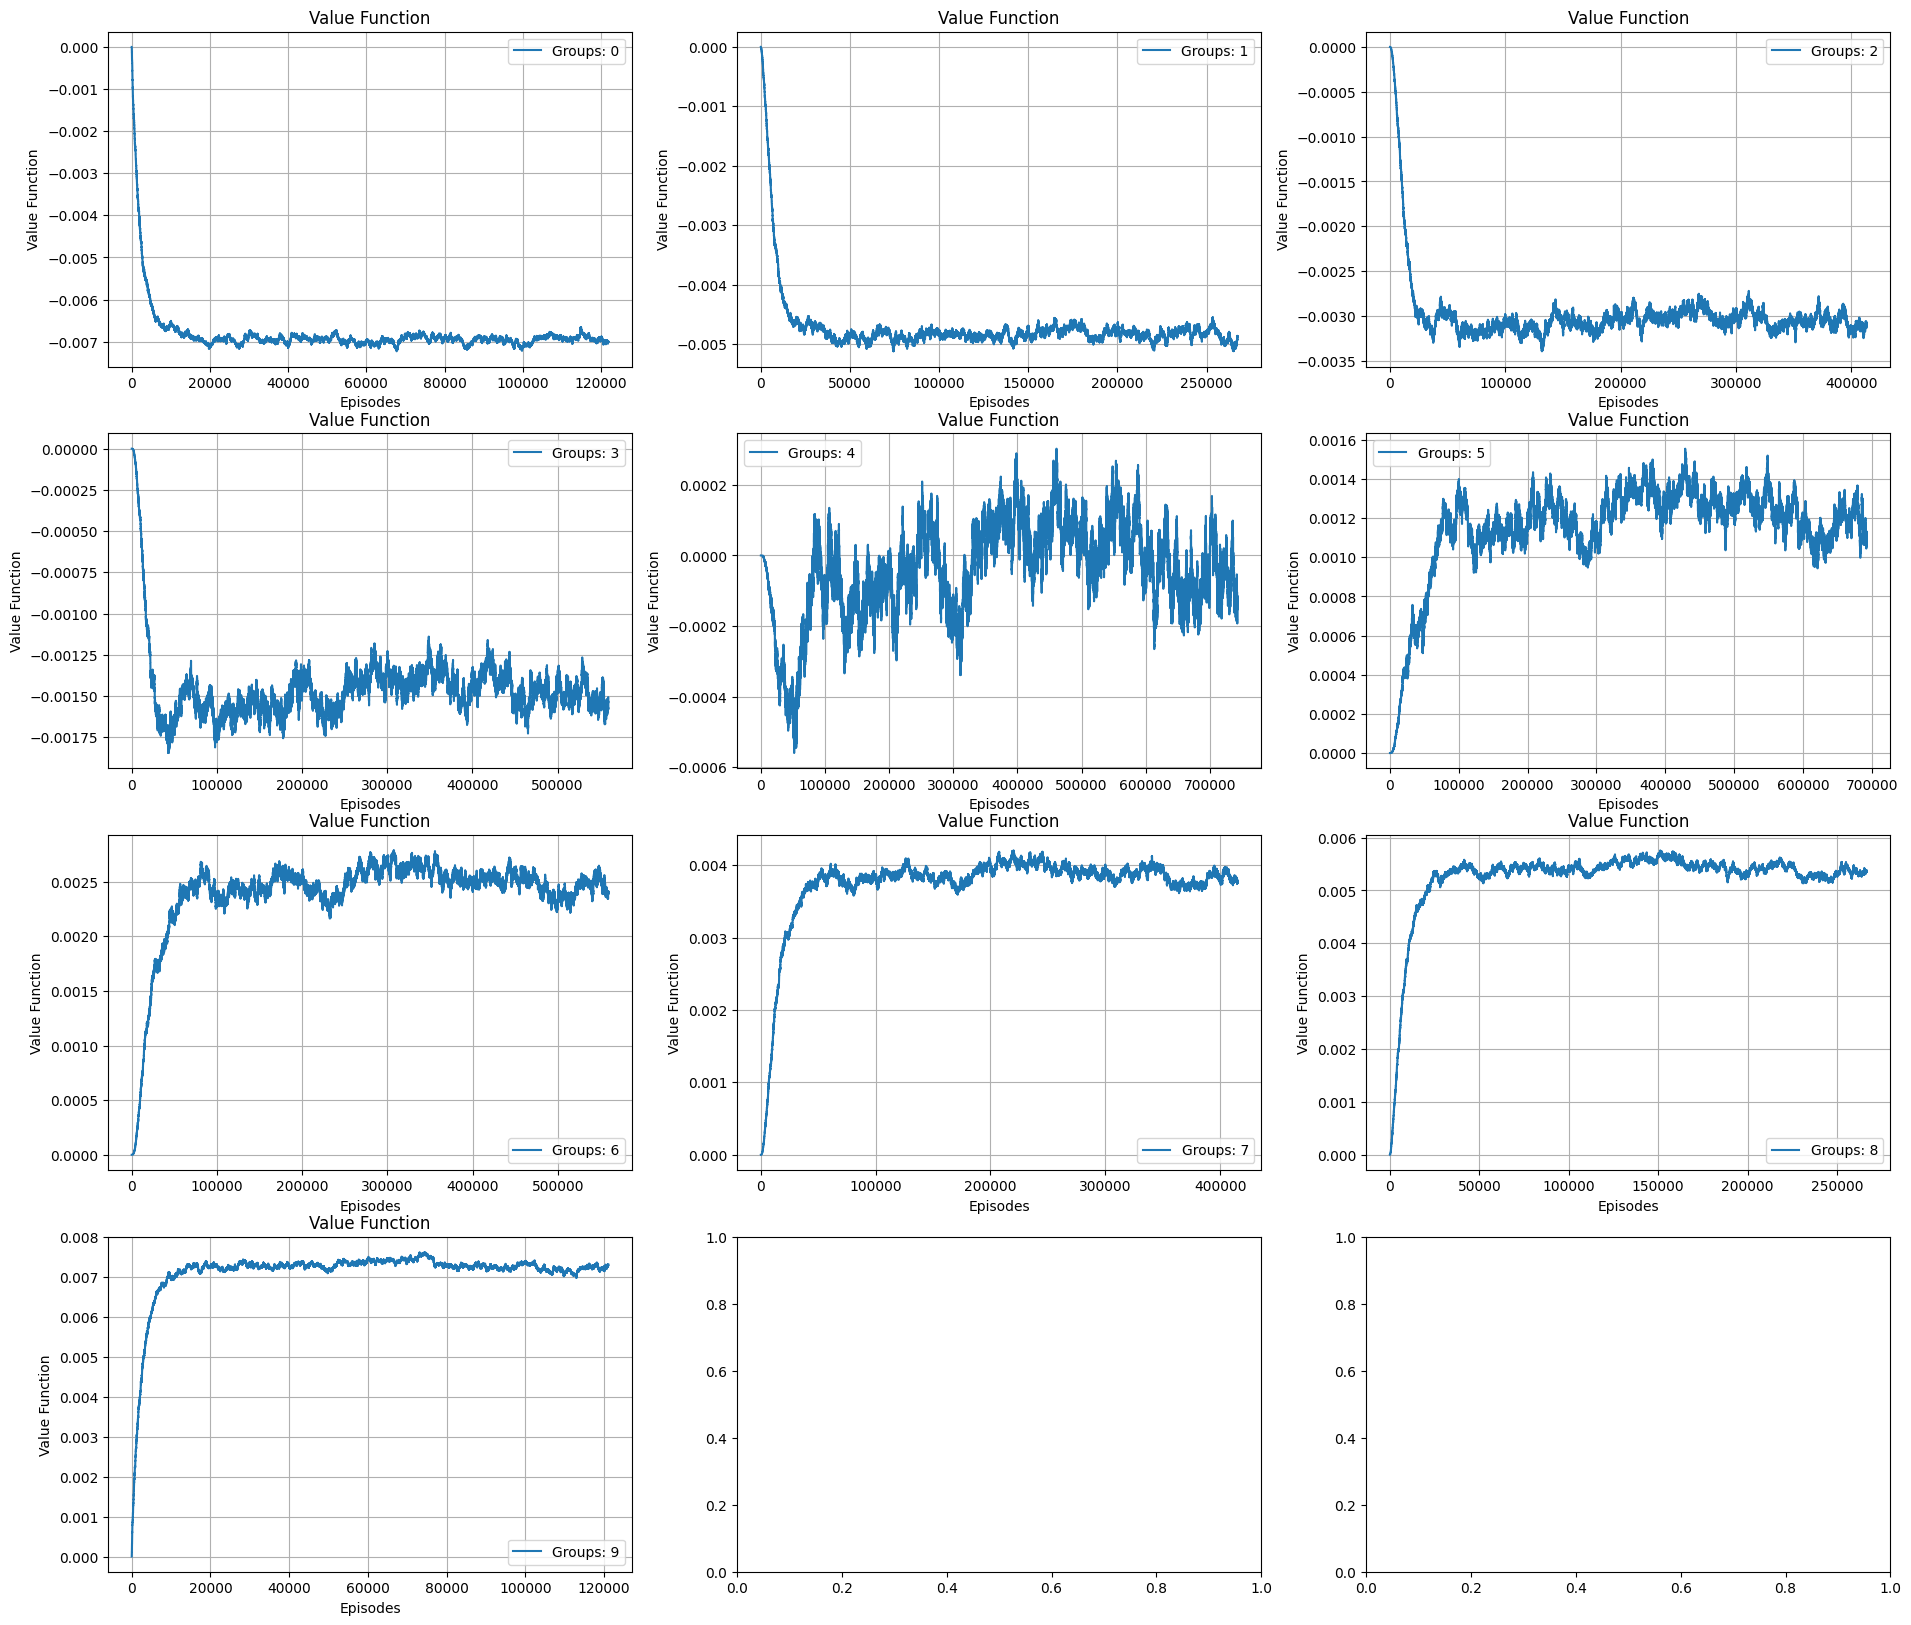

In [97]:
plot_result(W_HISTORY, title="Value Function", ylabel="Value Function")

### Plotting the average RMS error of the result

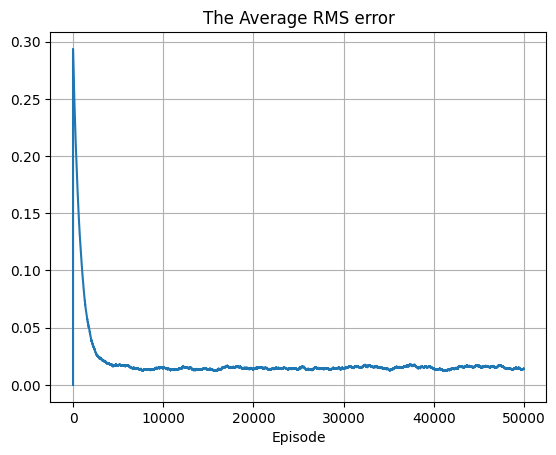

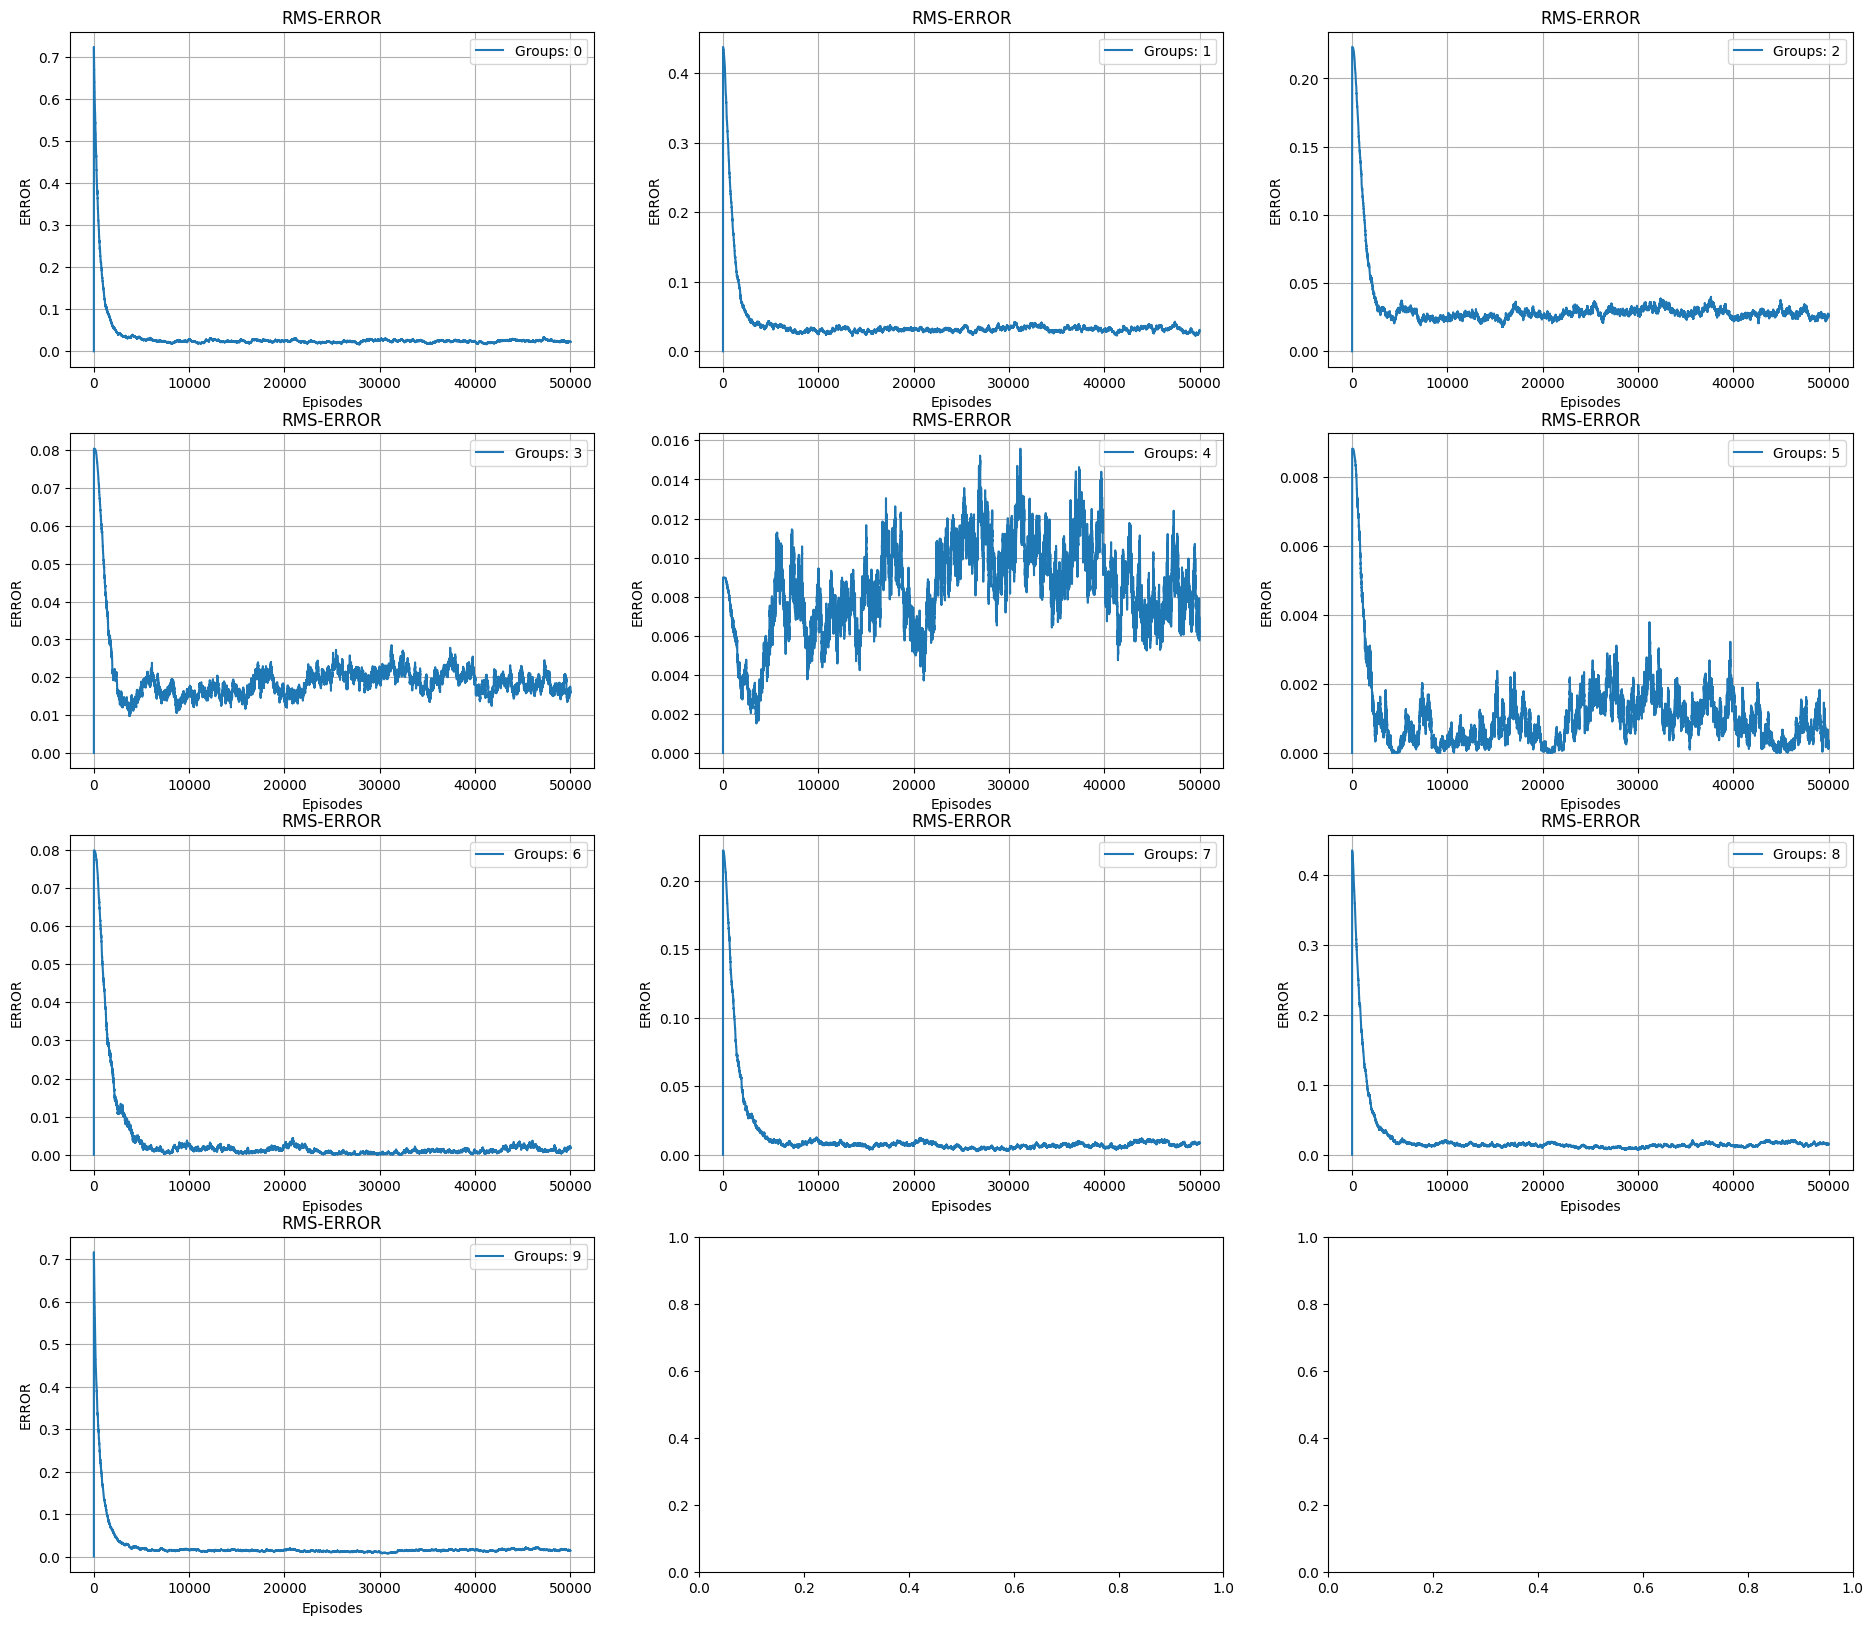

In [98]:
rms_error = np.array(RMS_ERROR)
avg_rms_error = np.mean(rms_error, axis=0)
plt.plot(avg_rms_error)
plt.title("The Average RMS error")
plt.xlabel("Episode")

plt.grid(True)

plot_result(RMS_ERROR, title="RMS-ERROR", ylabel="ERROR")